In [1]:
import pandas as pd
from gps_grid_map_creator import GPSGridMapCreator

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

# Example coordinates
lat1, lon1 = 39.975300, 116.452488  # Lower-left corner
lat2, lon2 = 41.367085, 122.651456  # Upper-right corner
grid_size_meter = 500  # Size of each grid in meters

mapCreator = GPSGridMapCreator(grid_size_meter)
mapCreator.create_grid_map(lat1, lon1, lat2, lon2)
print(mapCreator.find_grid_number(39.99, 117.5))


(2, 114, 39.98715717254236, 117.4918228913047, 1475)


In [5]:
import pandas as pd
from convert_minmax_location import LocationPreprocessor

locationPreprocessor = LocationPreprocessor()
id = 68

gap = 10
round_min = str(gap) + 'min'
round_sec = str(gap) + 's'
round_time = round_sec

user_id = locationPreprocessor.getUserId(id)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
seg_file = './Data/' + user_id + '/csv/' + user_id + '_segment.csv'
df = pd.read_csv(csv_file)
df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
df['datetime'] = df['datetime'].dt.round(round_time)

df = df.set_index('datetime').reset_index()
user_df = df.groupby('datetime')[df.columns[1:].to_list()].mean().reset_index()

# 시간 간격 계산
user_df['time_diff'] = user_df['datetime'].diff()

# 1분 이상인 경우 세그먼트로 분류
threshold = pd.Timedelta(minutes=1)
user_df['segment'] = (user_df['time_diff'] > threshold).cumsum()
user_df = user_df.drop(columns=['time_diff'])
user_df.to_csv(seg_file, index=False)
# user_df.head()

/tmp/ipykernel_644/3142186472.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_df = df.groupby('datetime')[df.columns[1:].to_list()].mean().reset_index()


In [9]:
user_df = pd.read_csv(seg_file)
user_df['datetime'] = pd.to_datetime(user_df['datetime'])
user_df.head()

,datetime,latitude,longitude,what,altitude,days,segment
0,2008-09-14 13:03:10,39.972909,116.418298,0.0,0.0,39705.543872,0
1,2008-09-14 13:03:20,39.972923,116.418236,0.0,0.0,39705.543987,0
2,2008-09-14 13:03:30,39.972791,116.418186,0.0,0.0,39705.544103,0
3,2008-09-14 13:03:40,39.972548,116.418203,0.0,0.0,39705.544219,0
4,2008-09-14 13:03:50,39.972287,116.418196,0.0,0.0,39705.544334,0


In [55]:
df = pd.read_csv('Data/068/csv/068_origin_grid_10s.csv')
df.head()
df_1 = df[df.columns[0:13].to_list()].copy()
# df_1 = pd.concat([df_1, df.iloc[:, 6:13]], axis=1) # ~ Hour + 100m
# # df_1 = pd.get_dummies(df_1, columns=['hour'], drop_first=True)

df_1 = pd.concat([df_1, df.iloc[:, 13:15]], axis=1) # 100m
df_1 = pd.concat([df_1, df.iloc[:, 21:]], axis=1) # 2000m
df_1 = pd.concat([df_1, df.iloc[:, 17:19]], axis=1) # 1000m
df_1 = pd.concat([df_1, df.iloc[:, 15:17]], axis=1) # 500m
df_1.head()
# df_1.columns.shape
# df.columns[0:13]

,datetime,latitude,longitude,days,x,y,year,month,week,weekend,...,grid_row_1500m,grid_col_1500m,grid_row_2000m,grid_col_2000m,grid_row_3000m,grid_col_3000m,grid_row_500m,grid_col_500m,grid_row_100m,grid_col_100m
0,2008-09-14 13:03:10,39.972909,116.418298,39705.543872,-58774.467688,913530.593053,2008,9,6,1,...,0,1,0,0,0,0,0,3,2,18
1,2008-09-14 13:03:20,39.972923,116.418236,39705.543987,-58779.739348,913532.094184,2008,9,6,1,...,0,1,0,0,0,0,0,3,2,18
2,2008-09-14 13:03:30,39.972791,116.418186,39705.544103,-58784.113148,913517.472051,2008,9,6,1,...,0,1,0,0,0,0,0,3,2,18
3,2008-09-14 13:03:40,39.972548,116.418203,39705.544219,-58782.916105,913490.451684,2008,9,6,1,...,0,1,0,0,0,0,0,3,2,18
4,2008-09-14 13:03:50,39.972287,116.418196,39705.544334,-58783.651864,913461.429808,2008,9,6,1,...,0,1,0,0,0,0,0,3,2,18


In [79]:
import os
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset

class SegmentDataset(Dataset):
    def __init__(self, data_dir, user_list, device, time_delta, y_timestep, length, label_attribute, sample_s, replace=False):
        self.data_dir = data_dir
        self.user_list = user_list
        self.device = device
        self.time_delta = time_delta
        self.y_timestep = y_timestep
        self.length = length
        self.label_attribute = label_attribute
        self.sample_s = sample_s
        self.replace = replace

        self.csv_file = '_origin_grid_10s.csv'
    
    def sampleSet(self, dataset):
        user_df = dataset.copy()
        user_df['datetime'] = pd.to_datetime(user_df['datetime'])
    
        # 세그먼트별 시작 시간과 끝 시간 추출 그리고, 시간 간격별 segment list 추출
        segment_info = user_df.groupby('segment')['datetime'].agg(['min', 'max'])
        segment_info = segment_info.reset_index()
        segment_info['time_gap'] = segment_info['max'] - segment_info['min']
        segment_info['over_time_delta'] = segment_info['time_gap'] >= pd.Timedelta(minutes=self.time_delta)
        segment_info = segment_info.loc[segment_info['over_time_delta'] == True, :]
        segment_list = segment_info['segment'].to_list()

        user_df = user_df.drop(columns=['datetime'])

        # segment_list 기반, sample 추출하여 mini-batch 형성
        mini_batch = []

        segment_list = np.random.choice(segment_list, size=self.sample_s, replace=self.replace)

        for seg_num in segment_list:
            seg_df = user_df.loc[user_df['segment'] == seg_num, :]
            if seg_df.shape[0] < length:
                # segment 길이가 짧다면, zero padding 진행
                fill_quota  = np.abs(length - seg_df.shape[0])
                zeros_r     = np.zeros([fill_quota, seg_df.shape[1]])
                cur_sample  = seg_df.copy()
                cur_sample  = np.concatenate([zeros_r, seg_df], axis = 0)
                mini_batch.append(cur_sample)
            else:
                # segment 에서 요구된 길이만큼 추출
                cur_sample = seg_df.iloc[:length, :]
                mini_batch.append(cur_sample)

        return np.array(mini_batch)
    
    def __getitem__(self, index):
        csv_file = str(self.data_dir) + str(self.user_list[index]) + '/csv/' + str(self.user_list[index]) + self.csv_file
        df = pd.read_csv(csv_file)
        
        df_1 = df[df.columns[0:13].to_list()].copy()
        # df_1 = pd.concat([df_1, df.iloc[:, 6:13]], axis=1) # ~ Hour + 100m
        # df_1 = pd.get_dummies(df_1, columns=['hour'], drop_first=True)

        df_1 = pd.concat([df_1, df.iloc[:, 13:15]], axis=1) # 100m
        df_1 = pd.concat([df_1, df.iloc[:, 21:]], axis=1) # 2000m
        df_1 = pd.concat([df_1, df.iloc[:, 17:19]], axis=1) # 1000m
        df_1 = pd.concat([df_1, df.iloc[:, 15:17]], axis=1) # 500m
        
        samples = self.sampleSet(df_1)
        
        # task_X, task_y 준비
        task_X = np.array(samples[:, :-self.y_timestep, 4:])
        task_y = np.array(samples[:, -self.y_timestep:, -self.label_attribute:])

        task_X = torch.from_numpy(task_X).double()
        task_y = torch.from_numpy(task_y).double()

        return task_X, task_y
    
    def __len__(self):
        # batch를 구성할 수 있는 총 수
        # 이 수에서 batch를 조정할 수 있다.
        # 몇 명의 user 로 나눠서 할 지
        return len(self.user_list)

In [78]:
# segment 기반, user별 mini-batch 를 추출

import numpy as np
import torch
import torch.nn as nn

min_length = 6
time_delta = 60
length = min_length * time_delta

y_timestep = min_length * 2
label_attribute = 2

samples_s = 10
replace = False
attribute = ['days','latitude', 'longitude']

user_df = pd.read_csv(seg_file)
user_df['datetime'] = pd.to_datetime(user_df['datetime'])

# 세그먼트별 시작 시간과 끝 시간 추출 그리고, 시간 간격별 segment list 추출
segment_info = user_df.groupby('segment')['datetime'].agg(['min', 'max'])
segment_info = segment_info.reset_index()
segment_info['time_gap'] = segment_info['max'] - segment_info['min']
segment_info['over_time_delta'] = segment_info['time_gap'] >= pd.Timedelta(minutes=time_delta)
segment_info = segment_info.loc[segment_info['over_time_delta'] == True, :]
segment_list = segment_info['segment'].to_list()
print(len(segment_list))

# segment_list 기반, sample 추출하여 mini-batch 형성
mini_batch = []

segment_list = np.random.choice(segment_list, size=samples_s, replace=replace)

for seg_num in segment_list:
    seg_df = user_df.loc[user_df['segment'] == seg_num, attribute]
    if seg_df.shape[0] < length:
        # segment 길이가 짧다면, zero padding 진행
        fill_quota  = np.abs(length - seg_df.shape[0])
        zeros_r     = np.zeros([fill_quota, seg_df.shape[1]])
        cur_sample  = seg_df.copy()
        cur_sample  = np.concatenate([zeros_r, seg_df], axis = 0)
        mini_batch.append(cur_sample)
    else:
        # segment 에서 요구된 길이만큼 추출
        cur_sample = seg_df.iloc[:length, :]
        mini_batch.append(cur_sample)

samples = np.array(mini_batch)
# samples = torch.from_numpy(samples).double()
print(f"samples.shape: {samples.shape}")
# samples[:2, :5, :]
# 8분의 data를 input 으로 넣고, 2분의 data를 output 으로 내는 ?
# or 5분의 data를 input 으로 넣고, 5분의 data를 output으로 내는?

NameError: name 'seg_file' is not defined

In [71]:
# task_X, task_y 준비
task_X = np.array(samples[:, :-y_timestep, :])
task_y = np.array(samples[:, -y_timestep:, -label_attribute:])

task_X = torch.from_numpy(task_X).double()
task_y = torch.from_numpy(task_y).double()

# batch 를 만들기위한 임시 코드, data_loader 에서는 이 부분 주석처리
task_X = torch.unsqueeze(task_X, axis = 0)
task_y = torch.unsqueeze(task_y, axis = 0)
print(f"task_x: {task_X.shape}, task_y: {task_y.shape}")

task_x: torch.Size([1, 10, 348, 3]), task_y: torch.Size([1, 10, 12, 2])


In [80]:
import torch
import torch.nn as nn

# MLP 모델
class MLP(nn.Module):
    def __init__(self, input_shape, y_timestep, label_attribute):
        super(MLP, self).__init__()
        
        self.input_shape = input_shape[-2] * input_shape[-1]
        self.y_timestep = y_timestep
        self.label_attribute = label_attribute
        self.output_shape = y_timestep * label_attribute
        
        self.fc1 = nn.Linear(self.input_shape, 256, dtype=torch.double)
        self.fc2 = nn.Linear(256, 256, dtype=torch.double)
        self.fc3 = nn.Linear(256, self.output_shape, dtype=torch.double)
        
    def forward(self, x):
        batch = torch._shape_as_tensor(x)[0]
        mini_batch = torch._shape_as_tensor(x)[1]
        time_step = torch._shape_as_tensor(x)[2]
        attribute = torch._shape_as_tensor(x)[3]

        in_shape_new = [-1] + [time_step * attribute]
        x = torch.reshape(x, in_shape_new)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        out_shape_new = [batch] + [-1] + [self.y_timestep] + [self.label_attribute]
        out = torch.reshape(x, out_shape_new)
        return out


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error as mse

# input_data = torch.tensor(input_data.values, dtype=torch.float32)
# target_data = torch.tensor(output_data.values, dtype=torch.float32)

def metricDist(y_true, y_pred):
    row = (y_pred[:,:,:,0] - y_true[:,:,:,0])**2
    col = (y_pred[:,:,:,1] - y_true[:,:,:,1])**2
    return torch.mean(row + col) ** 0.5

# args
data_dir = "Data/"#"data/geolife/Data/"
user_list = ["068", "003", "004"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

min_length = 6
time_delta = 10 # the length of segment is 10mins
length = min_length * time_delta

y_timestep = min_length * 2
x_attribute = 20
label_attribute = 2
sample_s = 10
replace = False

batch_size = 2

# Dataset
training_data    = SegmentDataset(data_dir, user_list, device, time_delta, y_timestep, length, label_attribute, sample_s, replace)
train_dataloader = DataLoader(training_data, batch_size, shuffle=False)

# Model 훈련 진행
model = MLP(input_shape=[(length-y_timestep), x_attribute], y_timestep = y_timestep, label_attribute=label_attribute)

model = model.to(torch.double)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(10):
    model.train()
    for train_idx, train_data in enumerate(train_dataloader, 0):
        task_X, task_y = train_data
        optimizer.zero_grad()
        output = model(task_X)
        loss = criterion(output, task_y)
        loss.backward()
        optimizer.step()

# 예측
with torch.no_grad():
    model.eval()
    predicted = model(task_X)
    loss = metricDist(task_y, predicted)
    print("target latitude, longitude:", task_y)
    print("Predicted latitude, longitude:", predicted)
    print(f'loss: {loss}')

target latitude, longitude: tensor([[[[  13.,   68.],
          [  13.,   68.],
          [  13.,   67.],
          [  13.,   67.],
          [  13.,   67.],
          [  13.,   67.],
          [  13.,   67.],
          [  13.,   66.],
          [  13.,   66.],
          [  13.,   66.],
          [  13.,   66.],
          [  13.,   66.]],

         [[ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.],
          [ 862., 2797.]],

         [[  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   37.],
          [  11.,   36.],
          [  11.,   36.],
          [  11.,   36.],
          [  11.,   36.]],

         [[  18.,   69.],
    

In [119]:
segment = user_df['segment'].unique()
user_df.groupby('segment')['what'].value_counts() > 20

# user_df.loc[user_df['segment'] == segment[3], :]

# 39.968885	116.419843
# 39.969592	116.418630

segment  what
0        0.0      True
182      0.0     False
193      0.0     False
200      0.0     False
207      0.0     False
                 ...  
980204   0.0     False
980214   0.0      True
980218   0.0     False
980228   0.0      True
980229   0.0      True
Name: what, Length: 4041, dtype: bool

In [ ]:
user_df.head()

In [60]:
import numpy as np
df = user_df.copy()
df = df.fillna(np.nan)
if str(df.iloc[11, -2]) == 'nan':
    print('true')
else:
    print('false')

true


In [1]:
# csv 파일 5분 단위로 전처리하기 (rounded)
# round_min 을 조절하여 round_min 간격으로 data를 전처리

from convert_minmax_location import LocationPreprocessor
from gps_grid_map_creator import GPSGridMapCreator
import numpy as np
import pandas as pd

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

locationPreprocessor = LocationPreprocessor()
valid_user_list = locationPreprocessor.get_valid_user_list()

days_min = 0.000696
gap = 10
round_min = str(gap) + 'min'
round_sec = str(gap) + 's'

lat1, lon1 = 39.975300, 116.452488  # Lower-left corner
lat2, lon2 = 41.367085, 122.651456  # Upper-right corner

# origin_grid_10min = just add grid in original csv file
# grid_10min        = from begin to end full data with fillna(ffill)
round_csv = '_origin_round_' + round_sec + '.csv'
grid_csv = '_origin_grid_' + round_sec + '.csv'
grid_list = [50, 100, 500, 1000, 1500, 2000, 3000]

for id in valid_user_list['valid_user_list']:
    print(f"user_id: {id}")
    user_id = locationPreprocessor.getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    rounded_file = './Data/' + user_id + '/csv/' + user_id + round_csv
    grid_file = './Data/' + user_id + '/csv/' + user_id + grid_csv

    df = pd.read_csv(csv_file)
    print(df.shape)
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
    df['datetime'] = df['datetime'].dt.round(round_sec)

    df = df.set_index('datetime').reset_index()
    user_df = df.groupby('datetime')[df.columns[1:].to_list()].mean().reset_index()
    user_df = locationPreprocessor.convert_coord_for_blender_for_user(user_df)

    user_df['datetime'] = pd.to_datetime(user_df['datetime'])
    
    # begin = user_df['datetime'][0]
    # end = user_df['datetime'][user_df.shape[0]-1]

    # print(f'begin: {begin}')
    # print(f'end: {end}')

    # date_df = pd.DataFrame({'datetime':pd.date_range(begin, end, freq=round_min)})
    # user_df = pd.merge(date_df, user_df, how='outer', on='datetime')
    
    # # add days 
    # start_days = user_df['days'][0]
    # end_days = start_days + (date_df.shape[0] * (days_min * gap))
    # days_list = np.arange(start_days, end_days, (days_min * gap))

    # user_df['days'] = days_list[:user_df.shape[0]]
    user_df['year'] = user_df['datetime'].dt.year
    user_df['month'] = user_df['datetime'].dt.month
    user_df['week'] = user_df['datetime'].dt.weekday
    user_df['weekend'] = np.where(user_df['week'] < 5, 0, 1)
    user_df['hour'] = user_df['datetime'].dt.hour
    user_df['day'] = user_df['datetime'].dt.day
    # user_df = user_df.fillna(method='ffill')

    # 시간 간격 계산
    user_df['time_diff'] = user_df['datetime'].diff()

    # 1분 이상인 경우 세그먼트로 분류
    threshold = pd.Timedelta(minutes=1)
    user_df['segment'] = (user_df['time_diff'] > threshold).cumsum()
    # user_df = user_df.drop(columns=['time_diff'])

    # save rounded file
    # user_df.to_csv(rounded_file, index=False)

    # grid process
    user_df = user_df.drop(columns=['altitude', 'what'])
    for grid_len in grid_list:
        mapCreator = GPSGridMapCreator(grid_len)
        mapCreator.create_grid_map(lat1, lon1, lat2, lon2)
        grid_row = 'grid_row_' + str(grid_len) + 'm' # row
        grid_col = 'grid_col_' + str(grid_len) + 'm' # column
        grid_lat = 'grid_lat_' + str(grid_len) + 'm' # lat
        grid_lon = 'grid_lon_' + str(grid_len) + 'm' # lon
        grid_num = 'grid_num_' + str(grid_len) + 'm' # num      
        user_df[grid_row], user_df[grid_col],_,_,_ = mapCreator.find_grid_number(user_df['latitude'], user_df['longitude'])
    # save grid filen
    user_df.to_csv(grid_file, index=False)


user_id: 0
(173870, 7)
min_lat: 22.147577, min_lon: 111.564595
max_lat: 41.367085, max_lon: 122.651456
user_id: 1
(108607, 7)
user_id: 3
(485226, 7)
user_id: 4
(439397, 7)
user_id: 5
(109046, 7)
user_id: 6
(31830, 7)
user_id: 7
(87217, 7)
user_id: 8
(77910, 7)
user_id: 9
(84616, 7)
user_id: 11
(90803, 7)
user_id: 13
(291182, 7)
user_id: 14
(388213, 7)
user_id: 15
(87736, 7)
user_id: 16
(89272, 7)
user_id: 18
(47279, 7)
user_id: 19
(47824, 7)
user_id: 21
(2385, 7)
user_id: 24
(263482, 7)
user_id: 26
(148411, 7)
user_id: 27
(15508, 7)
user_id: 29
(83844, 7)
user_id: 30
(615948, 7)
user_id: 31
(20412, 7)
user_id: 32
(26468, 7)
user_id: 33
(69974, 7)
user_id: 34
(166670, 7)
user_id: 35
(312042, 7)
user_id: 36
(251973, 7)
user_id: 37
(191324, 7)
user_id: 38
(250393, 7)
user_id: 39
(267737, 7)
user_id: 40
(56013, 7)
user_id: 43
(96246, 7)
user_id: 44
(76846, 7)
user_id: 45
(9743, 7)
user_id: 46
(21818, 7)
user_id: 47
(790, 7)
user_id: 48
(9076, 7)
user_id: 49
(2614, 7)
user_id: 50
(336859, 7

In [21]:
import pandas as pd
from convert_minmax_location import LocationPreprocessor
from gps_grid_map_creator import GPSGridMapCreator

lat1, lon1 = 39.975300, 116.452488  # Lower-left corner
lat2, lon2 = 41.367085, 122.651456  # Upper-right corner

grid_list = [50, 100, 500, 1000, 1500, 2000, 3000]

lat_list = []
lon_list = []
for grid_len in grid_list:
    mapCreator = GPSGridMapCreator(grid_len)
    mapCreator.create_grid_map(lat1, lon1, lat2, lon2)
    lat, lon = mapCreator.get_num_lat_lon()
    lat_list += [lat]
    lon_list += [lon]

df = pd.DataFrame({'grid':grid_list,
                   'latitude':lat_list,
                   'longitude':lon_list})
df.to_csv('grid_map_coordinate.csv', index=False)

In [39]:
import pandas as pd

df = pd.read_csv('grid_map_coordinate.csv')

width = df.loc[df['grid']==1000, 'latitude'].values[0]
width
height = df.loc[df['grid']==1000, 'longitude'].values[0]
height
df.head()

,grid,latitude,longitude
0,50,2347,6799
1,100,1173,3399
2,500,234,679
3,1000,117,339
4,1500,78,226


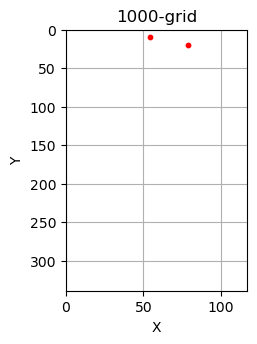

In [58]:


import matplotlib.pyplot as plt

# 지도 크기 정의
grid = 1000
width = df.loc[df['grid']==grid, 'latitude'].values[0]
height = df.loc[df['grid']==grid, 'longitude'].values[0]

# 찍을 좌표 정의
coordinates = [(54, 10), (79, 20)]

# 산점도 그래프 생성
plt.figure(figsize=(width/50, height/100))  # 그림 크기 조정
plt.scatter(*zip(*coordinates), color='red', marker='o', s=10)  # 좌표 찍기
plt.xlim(0, width)    # x축 범위 설정
plt.ylim(0, height)   # y축 범위 설정
plt.gca().invert_yaxis()  # y축 반전하여 지도 좌표와 일치
plt.title(str(grid) + '-grid')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
# plt.savefig("map_with_coordinates.png")  # 그래프를 이미지로 저장
plt.show()

# print("지정한 좌표가 있는 지도가 map_with_coordinates.png로 저장되었습니다.")


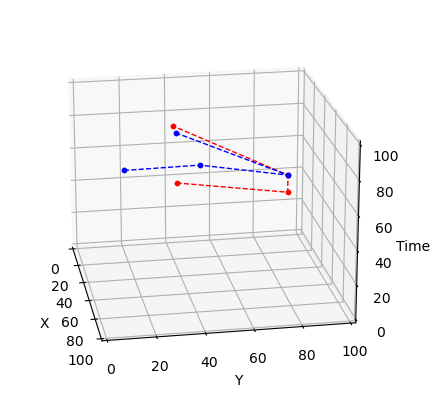

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 지도 크기 정의
width = 100
height = 100
time = 100

# 찍을 좌표 정의
coordinates_x = [(30, 40, 50), (70, 80, 60), (70, 80, 70), (20, 40, 80)]
coordinates_y = [(10, 20, 50), (30, 50, 60), (70, 80, 70), (30, 40, 80)]

# 3D 그래프 생성
fig = plt.figure(figsize=(width/20, height/20))
ax = fig.add_subplot(111, projection='3d')

# 좌표 찍기
for coord in coordinates_x:
    ax.scatter(*coord, color='red', marker='o', s=10)

# 좌표 찍기
for coord in coordinates_y:
    ax.scatter(*coord, color='blue', marker='o', s=10)

# line 추가
ax.plot(*zip(*coordinates_x), color='red', linestyle='--', linewidth=1)
ax.plot(*zip(*coordinates_y), color='blue', linestyle='--', linewidth=1)

# 축 범위 설정
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_zlim(0, time)

# 축 레이블 설정
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Time")

# 시간 축을 기준으로 회전
for angle in range(0, 360, 10):
    ax.view_init(elev=20, azim=angle)  # 시야 각도 변경

# plt.title("3d-map")
# # plt.savefig("3d_map_with_coordinates.png")  # 그래프를 이미지로 저장
# plt.show()

# print("지정한 좌표가 있는 3D 지도가 3d_map_with_coordinates.png로 저장되었습니다.")


In [14]:
import pandas as pd
days_min = 0.000696
gap = 10
round_min = str(gap) + 'min'
round_sec = str(gap) + 's'
grid_csv = '_origin_grid_' + round_sec + '.csv'
user_id = '035'
grid_file = './Data/' + user_id + '/csv/' + user_id + grid_csv

df = pd.read_csv(grid_file)
df = df.drop(columns=['time_diff'])
df.iloc[:, 19:21]
# columns = ['datetime','latitude', 'longitude', 'days']
# df_1 = df[df.columns[0:14].to_list()].copy()
# df_1 = df[columns].copy()
# df_1.head()

,grid_row_1000m,grid_col_1000m
0,0,7
1,0,7
2,0,7
3,0,7
4,0,7
...,...,...
152680,0,6
152681,0,6
152682,0,6
152683,0,6


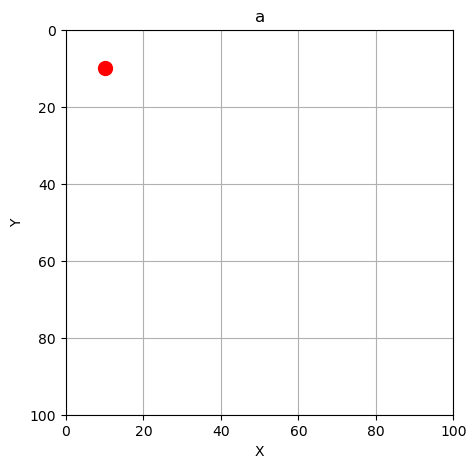

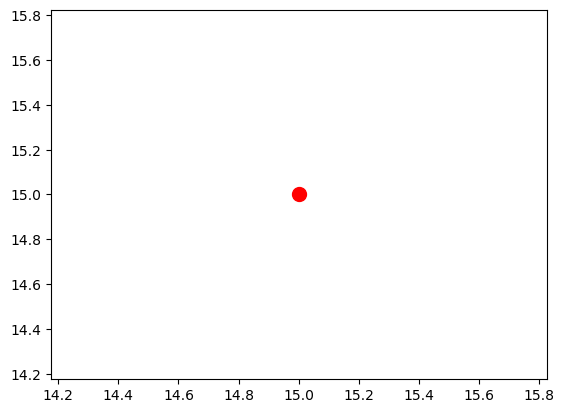

In [54]:
import matplotlib.pyplot as plt
import time

# 지도 크기 정의
width = 100
height = 100

# 찍을 좌표 정의 (시간과 함께)
coordinates = [
    ((10, 10), time.time()),  # 첫 번째 좌표 (현재 시간)
    ((15, 15), time.time() + 5)  # 두 번째 좌표 (5초 후 시간)
]

# 산점도 그래프 생성
plt.figure(figsize=(width/20, height/20))  # 그림 크기 조정
plt.xlim(0, width)  # x축 범위 설정
plt.ylim(0, height)  # y축 범위 설정
plt.gca().invert_yaxis()  # y축 반전하여 지도 좌표와 일치
plt.title("a")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

for coord, timestamp in coordinates:
    plt.scatter(*coord, color='red', marker='o', s=100)  # 좌표 찍기
    # plt.savefig(f"map_with_coordinates_{timestamp:.0f}.png")  # 그래프를 이미지로 저장
    plt.pause(1)  # 1초 대기
    plt.clf()  # 그래프 초기화


In [ ]:
# grid.csv 파일의 column 확인 코드
import pandas as pd

user_id = '067'

gap = 10
round_min = str(gap) + 'min'
grid_csv = '_grid_' + round_min + '.csv'
grid_file = './Data/' + user_id + '/csv/' + user_id + grid_csv

train_file = './Data/' + user_id + '/csv/' + user_id + '_train_set.csv'
valid_file = './Data/' + user_id + '/csv/' + user_id + '_valid_set.csv'
test_file = './Data/' + user_id + '/csv/' + user_id + '_test_set.csv'

df = pd.read_csv(grid_file)
print(df.info())
# print(df.tail())

# columns = df.loc[:, :'grid_col_50m'].columns.to_list() #df.columns[:'grid_col_50m'].to_list() #+ df.columns[58:60].to_list()
columns = df.columns[2:11].to_list() #+ df.columns[15:17].to_list()
df_1 = df[columns].copy()
df_1 = pd.get_dummies(df_1, columns=['hour'], drop_first=True)
df_1 = pd.concat([df_1, df.iloc[:, 15:17]], axis=1)
print(df_1.columns)
print(df_1.tail())

df_train = pd.read_csv(train_file)
df_valid = pd.read_csv(valid_file)
df_test = pd.read_csv(test_file)

print(f"train: {df_train.shape[0]}")
print(f"valid: {df_valid.shape[0]}")
print(f"test: {df_test.shape[0]}")


In [80]:
from convert_minmax_location import LocationPreprocessor
import numpy as np

locationPreprocessor = LocationPreprocessor()
valid_user_list = locationPreprocessor.get_valid_user_list()
user_id_list = []
df_len_list = []
ori_len_list = []
begin_day_list = []
end_day_list = []
for id in valid_user_list['valid_user_list']:
    print(f"user_id: {id}")
    user_id = locationPreprocessor.getUserId(id)
    csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_origin_round_10min.csv'
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    user_df = pd.read_csv(csv_convert_file)
    orig_df = pd.read_csv(csv_file)
    orig_df['datetime'] = pd.to_datetime(orig_df['date'] + " " + orig_df['time'])

    user_id_list += [user_id]
    df_len_list += [user_df.shape[0]]
    ori_len_list += [orig_df.shape[0]]

    begin_day_list += [orig_df.iloc[0, -1]]
    end_day_list += [orig_df.iloc[-1, -1]]

user_df = pd.DataFrame({'user_id':user_id_list,
                        'begin_date':begin_day_list,
                        'end_date':end_day_list,
                        'original_len':ori_len_list,
                        'rounded_len':df_len_list})
user_df.head(5)

user_id: 0
user_id: 1
user_id: 3
user_id: 4
user_id: 5
user_id: 6
user_id: 7
user_id: 8
user_id: 9
user_id: 11
user_id: 13
user_id: 14
user_id: 15
user_id: 16
user_id: 18
user_id: 19
user_id: 21
user_id: 24
user_id: 26
user_id: 27
user_id: 29
user_id: 30
user_id: 31
user_id: 32
user_id: 33
user_id: 34
user_id: 35
user_id: 36
user_id: 37
user_id: 38
user_id: 39
user_id: 40
user_id: 43
user_id: 44
user_id: 45
user_id: 46
user_id: 47
user_id: 48
user_id: 49
user_id: 50
user_id: 51
user_id: 54
user_id: 55
user_id: 56
user_id: 57
user_id: 58
user_id: 59
user_id: 61
user_id: 63
user_id: 64
user_id: 65
user_id: 66
user_id: 67
user_id: 68
user_id: 69
user_id: 70
user_id: 73
user_id: 74
user_id: 75
user_id: 76
user_id: 77
user_id: 78
user_id: 79
user_id: 80
user_id: 81
user_id: 85
user_id: 86
user_id: 88
user_id: 93
user_id: 94
user_id: 95
user_id: 96
user_id: 97
user_id: 98
user_id: 100
user_id: 101
user_id: 102
user_id: 103
user_id: 104
user_id: 105
user_id: 106
user_id: 109
user_id: 110
user

,user_id,begin_date,end_date,original_len,rounded_len
0,000,2008-10-23 02:53:04,2009-07-05 07:45:15,173870,2286
1,001,2008-10-23 05:53:05,2008-12-15 00:31:18,108607,940
2,003,2008-10-23 17:58:54,2009-07-05 07:45:15,485226,5969
3,004,2008-10-23 17:58:52,2009-07-29 06:16:11,439397,5671
4,005,2008-10-24 04:12:30,2009-03-19 05:46:37,109046,1249


In [102]:
import pandas as pd

# 100 일 이상 좌표 수집한 user 45명
# user_df.to_csv('origin_round_10min_user_list.csv', index=False)

df_1 = pd.read_csv('origin_round_10min_user_list.csv')
df = pd.read_csv('round_10min_user_list.csv')

df = df.merge(df_1, how='inner', on = 'user_id')
df = df.loc[df['rounded_len_y'] > 2000, :]
df['extra_ratio'] = round(df['rounded_len_x'] / df['rounded_len_y'], 1)

df = df.sort_values(['extra_ratio'], ascending=True)

df = df.rename(columns = {'rounded_len_y':'rounded_10min_len',
                          'rounded_len_x':'date_rounded',
                          'original_len_x':'original_len'})
df = df[['user_id','begin_date','end_date','date_rounded','original_len', 'rounded_10min_len', 'extra_ratio']]
df.head()
df.to_csv('extra_ratio.csv', index=False)

# df = df.loc[df['rounded_len'] >= 14400, :]
# df['user_id'].to_list()
# df.head(20)
# df.sort_values('rounded_len', ascending=False)
# ['068', '030', '085', '003', '004']","['065', '067']"

In [103]:
import pandas as pd
user = pd.read_csv('extra_ratio.csv')
user.head(10)
# user = user.sort_values('original_len', ascending=False)
# user = user[['user_id', 'original_len', 'extra_rounded', 'rounded_10min', 'extra_ratio']]
# user.rename(columns={'extra_rounded':'rounded_10min',
#                      'rounded_10min':'rounded_len'})

,user_id,begin_date,end_date,date_rounded,original_len,rounded_10min_len,extra_ratio
0,35,2009-02-09 10:48:38,2009-04-27 06:14:45,11061,312042,3162,3.5
1,3,2008-10-23 17:58:54,2009-07-05 07:45:15,36660,485226,5969,6.1
2,30,2009-01-13 02:32:22,2009-07-29 01:40:07,28364,615948,4320,6.6
3,4,2008-10-23 17:58:52,2009-07-29 06:16:11,40107,439397,5671,7.1
4,39,2009-02-11 09:59:38,2009-07-15 00:56:11,22123,267737,3098,7.1
5,24,2008-12-16 01:00:33,2009-05-26 10:51:12,23244,263482,2648,8.8
6,68,2008-09-14 13:03:08,2009-09-13 12:51:15,52416,937876,5073,10.3
7,38,2009-02-06 12:11:02,2009-07-23 18:13:12,24085,250393,2069,11.6
8,14,2008-10-20 05:45:00,2009-04-17 01:50:18,25754,388213,2136,12.1
9,0,2008-10-23 02:53:04,2009-07-05 07:45:15,36751,173870,2286,16.1


In [ ]:
import pandas as pd

user_id = '085'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user_df = pd.read_csv(csv_convert_file)
user_df.head(1)

# user_df = user_df[['days','month','week','weekend','hour','day','x','y']]
# user_df = pd.get_dummies(user_df, columns=['week','month'], drop_first=True)
# user_xy = user_df.loc[:, ['x', 'y']]
# user_df = user_df.drop(columns=['x', 'y'])
# pd.concat([user_df, user_xy], axis=1)

df_1 = user_df[['days','month','week','weekend','hour','day','x','y']]
df_1 = pd.get_dummies(df_1, columns=['week','month'], drop_first=True)
df_xy = df_1.loc[:, ['x', 'y']]
df_1 = df_1.drop(columns=['x', 'y'])
df_1 = pd.concat([df_1, df_xy], axis=1)
df_1.head(1)

In [ ]:
user_df = pd.DataFrame({"user_id":user_id_list,
                        "data_vol":df_len_list})
user_df = user_df.sort_values(['data_vol'], ascending=False)
user_df.to_csv('user_data_volumn.csv', index=False)

print(user_df.head(5))
user_df.iloc[:5, 0].to_list()

In [ ]:
sample_s = 1
sample_q = 1

args_epoch = 1200
args_patience = 300

gap_min = 12 # 1 min
gap = gap_min

y_timestep = 100 # must be less than length
length = 15000

train_list      = ['068', '030', '085', '004']#, '085']
validation_list = ['067']#, '085']
test_list       = ['067']#, '085']

conf_df = pd.DataFrame({'sample_s':[sample_s],
                        'sample_q':[sample_q],
                        'epoch':[args_epoch],
                        'patience':[args_patience],
                        'gap':[gap],
                        'y_timestep':[y_timestep],
                        'length':[length],
                        'train_list':[train_list],
                        'val_list':[validation_list],
                        'test_list':[test_list]})
conf_df

In [ ]:
user_df.loc[user_df['user_id'] == '001']

In [ ]:
user_location_df_pre = user_location_df.copy()
user_location_df_pre = user_location_df_pre.set_index('user_id', drop=True).copy()
user_location_df_pre.head(2)

X = ['min_lat', 'min_lon', 'max_lat', 'max_lon']
q1 = user_location_df_pre[X].quantile(0.25)
q3 = user_location_df_pre[X].quantile(0.75)
iqr = (q3-q1) * 1.5

cond1 = user_location_df_pre[X] >= (q1 - iqr)
user_location_df_pre = user_location_df_pre[cond1].dropna().copy()
print(user_location_df_pre.shape)

cond2 = user_location_df_pre[X] <= (q3 + iqr)
user_location_df_pre = user_location_df_pre[cond2].dropna().copy()
print(user_location_df_pre.shape)
user_location_df_pre.min()
user_location_df_pre.max()

In [ ]:
import math

PI = 3.14159265358979323846

def distance(lat1, lon1, lat2, lon2, unit):
    deg2rad_multiplier = PI / 180
    lat1 = lat1 * deg2rad_multiplier
    lon1 = lon1 * deg2rad_multiplier
    lat2 = lat2 * deg2rad_multiplier
    lon2 = lon2 * deg2rad_multiplier

    radius = 6378.137  # Earth mean radius defined by WGS84
    dlon = lon2 - lon1
    distance = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(dlon)) * radius
    
    # (kilometers, miles, nautical miles)
    if unit == 'K':
        return distance
    elif unit == 'M':
        return distance * 0.621371192
    elif unit == 'N':
        return distance * 0.539956803
    else:
        return 0

# Example usage:
result = distance(37.7749, -122.4194, 34.0522, -118.2437, 'K') * 1000
print(result)

In [ ]:
min_lat = 39.975300
min_lon = 116.452488
max_lat = 41.367085
max_lon = 122.651456

width = round(distance(39.975300, 122.651456, 41.367085, 122.651456, 'K'), 3)
height = round(distance(41.367085, 116.452488, 41.367085, 122.651456, 'K'), 3)
print(width)
print(height)
# up_width = 154.933
# down_width = 154.933
# left_height = 528.706
# right_hegith = 517.778

In [ ]:
import numpy as np
import pandas as pd

class GPSGridMapCreator():
    def __init__(self, grid_size_meter):
        self.grid_size_meter = grid_size_meter
        self.lat1 = 0
        self.lon1 = 0
        self.grid_numbers = 0
        self.lat_degrees = 0
        self.long_degrees = 0
        self.num_lat = 0
        self.num_lon = 0
        
    def km_to_degrees(self, latitude, kilometers):
        # Earth's radius in kilometers
        earth_radius_km = 6371.0

        # Convert kilometers to radians
        angle_rad = kilometers / earth_radius_km

        # Convert radians to degrees
        angle_deg = np.degrees(angle_rad)

        # Correction factor for latitude
        lat_correction = np.cos(np.radians(latitude))

        # Convert degrees to adjusted degrees
        adjusted_degrees = angle_deg / lat_correction

        return adjusted_degrees

    def meter_to_degrees(self, latitude, meters):
        # Convert meters to kilometers
        kilometers = meters / 1000

        # Convert kilometers to degrees using the km_to_degrees function
        degrees = self.km_to_degrees(latitude, kilometers)

        return degrees

    def create_grid_map(self, lat1, lon1, lat2, lon2):
        self.lat1 = lat1
        self.lon1 = lon1
        # Convert grid size from meters to degrees
        self.lat_degrees = self.meter_to_degrees((lat1 + lat2) / 2, self.grid_size_meter)
        self.lon_degrees = self.meter_to_degrees((lon1 + lon2) / 2, self.grid_size_meter)

        # print(f"lat_degrees: {self.lat_degrees}, lon_degree: {self.lon_degrees}")
        # Calculate the number of grid points in latitude and longitude directions
        self.num_lat = int(np.abs(lat2 - lat1) / np.abs(self.lat_degrees))
        self.num_lon = int(np.abs(lon2 - lon1) / np.abs(self.lon_degrees))
        # print(f"lon2 - lon1: {np.abs(lon2 - lon1)}")
        # print(f"num_lat: {self.num_lat}, num_lon: {self.num_lon}")

        # Generate latitude and longitude grid points
        latitudes = np.linspace(lat1, lat2, self.num_lat)
        longitudes = np.linspace(lon1, lon2, self.num_lon)

        # print(f"the num of latitudes: {len(latitudes)}")
        # print(f"the num of longitude: {len(longitudes)}")
        # print(latitudes)
        # print(longitudes)
        # Create a 2D grid for numbering
        self.grid_numbers = np.arange(0, (self.num_lat + 1) * (self.num_lon + 1)).reshape(self.num_lat + 1, self.num_lon + 1)
        print(f"gird_number: {self.grid_numbers.shape[0] * self.grid_numbers.shape[1]}")

    def find_grid_number(self, lat, lon):
        grid_lat = int((lat - self.lat1) / np.abs(self.lat_degrees))
        grid_lon = int((lon - self.lon1) / np.abs(self.lon_degrees))
        gird_number = grid_lat * (self.num_lon + 1) + grid_lon + 1
        return gird_number, grid_lat, grid_lon

# Example coordinates
lat1, lon1 = 39.975300, 116.452488  # Lower-left corner
lat2, lon2 = 41.367085, 122.651456  # Upper-right corner
grid_size_meter = 100  # Size of each grid in meters

mapCreator = GPSGridMapCreator(grid_size_meter)
mapCreator.create_grid_map(lat1, lon1, lat2, lon2)
print(mapCreator.find_grid_number(39.99, 117.5))
print("done")
# 3991600
# 15966400

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def km_to_degrees(latitude, kilometers):
    # Earth's radius in kilometers
    earth_radius_km = 6371.0

    # Convert kilometers to radians
    angle_rad = kilometers / earth_radius_km

    # Convert radians to degrees
    angle_deg = np.degrees(angle_rad)

    # Correction factor for latitude
    lat_correction = np.cos(np.radians(latitude))

    # Convert degrees to adjusted degrees
    adjusted_degrees = angle_deg / lat_correction

    return adjusted_degrees

def meter_to_degrees(latitude, meters):
    # Convert meters to kilometers
    kilometers = meters / 1000

    # Convert kilometers to degrees using the km_to_degrees function
    degrees = km_to_degrees(latitude, kilometers)

    return degrees

def create_grid_map(lat1, lon1, lat2, lon2, grid_size_meter):
    # Convert grid size from meters to degrees
    lat_degrees = meter_to_degrees((lat1 + lat2) / 2, grid_size_meter)
    lon_degrees = meter_to_degrees((lon1 + lon2) / 2, grid_size_meter)

    print(f"lat_degrees: {lat_degrees}, lon_degree: {lon_degrees}")
    # Calculate the number of grid points in latitude and longitude directions
    num_lat = int(np.abs(lat2 - lat1) / np.abs(lat_degrees))
    num_lon = int(np.abs(lon2 - lon1) / np.abs(lon_degrees))
    print(f"lon2 - lon1: {np.abs(lon2 - lon1)}")
    print(f"num_lat: {num_lat}, num_lon: {num_lon}")

    # Calculate the latitude and longitude increments
    # lat_increment = (lat2 - lat1) / num_lat
    # lon_increment = (lon2 - lon1) / num_lon

    # Generate latitude and longitude grid points
    latitudes = np.linspace(lat1, lat2, num_lat)
    longitudes = np.linspace(lon1, lon2, num_lon)

    print(f"the num of latitudes: {len(latitudes)}")
    print(f"the num of longitude: {len(longitudes)}")
    print(longitudes)
    # Create a 2D grid for numbering
    grid_numbers = np.arange(0, (num_lat + 1) * (num_lon + 1)).reshape(num_lat + 1, num_lon + 1)

    # # Plot the grid lines
    # for lat in latitudes:
    #     ax.plot([lon1, lon2], [lat, lat], color='black', linewidth=0.5, transform=ccrs.PlateCarree())
    # for lon in longitudes:
    #     ax.plot([lon, lon], [lat1, lat2], color='black', linewidth=0.5, transform=ccrs.PlateCarree())

    # Plot the numbers on the grid
    # for i in range(num_lat + 1):
    #     for j in range(num_lon + 1):
    #         ax.text(lon1 + j * lon_increment, lat1 + i * lat_increment, str(grid_numbers[i, j]),
    #                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree())

    # ax.coastlines()
    # plt.show()

# Example coordinates
lat1, lon1 = 37.0, -122.0  # Lower-left corner
lat2, lon2 = 38.0, -121.0  # Upper-right corner
grid_size_meter = 1000  # Size of each grid in meters

create_grid_map(lat1, lon1, lat2, lon2, grid_size_meter)
print("done")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def km_to_degrees(latitude, kilometers):
    earth_radius_km = 6371.0
    angle_rad = kilometers / earth_radius_km
    angle_deg = np.degrees(angle_rad)
    lat_correction = np.cos(np.radians(latitude))
    adjusted_degrees = angle_deg / lat_correction
    return adjusted_degrees

def meter_to_degrees(latitude, meters):
    kilometers = meters / 1000
    degrees = km_to_degrees(latitude, kilometers)
    return degrees

def find_grid_number(lat, lon, lat1, lon1, lat_degrees, lon_degrees):
    grid_lat = int((lat - lat1) / lat_degrees)
    grid_lon = int((lon - lon1) / lon_degrees)
    return grid_lat, grid_lon

def create_grid_map(lat1, lon1, lat2, lon2, grid_size_meter):
    lat_degrees = meter_to_degrees((lat1 + lat2) / 2, grid_size_meter)
    lon_degrees = meter_to_degrees((lon1 + lon2) / 2, grid_size_meter)

    num_lat = int(np.abs(lat2 - lat1) / lat_degrees)
    num_lon = int(np.abs(lon2 - lon1) / lon_degrees)

    lat_increment = (lat2 - lat1) / num_lat
    lon_increment = (lon2 - lon1) / num_lon

    latitudes = np.linspace(lat1, lat2, num_lat)
    longitudes = np.linspace(lon1, lon2, num_lon)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_global()
    ax.stock_img()

    for lat in latitudes:
        ax.plot([lon1, lon2], [lat, lat], color='black', linewidth=0.5, transform=ccrs.PlateCarree())
    for lon in longitudes:
        ax.plot([lon, lon], [lat1, lat2], color='black', linewidth=0.5, transform=ccrs.PlateCarree())

    for i in range(num_lat + 1):
        for j in range(num_lon + 1):
            ax.text(lon1 + j * lon_increment, lat1 + i * lat_increment, str(i * (num_lon + 1) + j + 1),
                    horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree())

    # Example input coordinates
    input_coordinates = [(37.5, -121.5), (37.3, -122.3), (37.7, -122.7)]
    for lat, lon in input_coordinates:
        grid_lat, grid_lon = find_grid_number(lat, lon, lat1, lon1, lat_degrees, lon_degrees)
        ax.text(lon, lat, f"{grid_lat * (num_lon + 1) + grid_lon + 1} ({grid_lat},{grid_lon})",
                horizontalalignment='center', verticalalignment='center', color='red', fontsize=8, transform=ccrs.PlateCarree())

    ax.coastlines()

    plt.show()

# Example coordinates
lat1, lon1 = 37.0, -122.0  # Lower-left corner
lat2, lon2 = 38.0, -121.0  # Upper-right corner
grid_size_meter = 1000  # Size of each grid in meters

create_grid_map(lat1, lon1, lat2, lon2, grid_size_meter)


In [ ]:
valid_user_list = user_location_df_pre.index
valid_user_list = pd.DataFrame({'valid_user_list':user_location_df_pre.index})


In [ ]:
min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

X = ['latitude', 'longitude', 'x', 'y']
user_min_df = pd.DataFrame(columns=X)
user_max_df = pd.DataFrame(columns=X)
for user_id in valid_user_list['valid_user_list']:
    # user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
    user0 = pd.read_csv(csv_file)
    min_df = pd.DataFrame(data=user0[X].min()).transpose()
    max_df = pd.DataFrame(data=user0[X].max()).transpose()
    
    user_min_df = pd.concat([user_min_df, min_df])
    user_max_df = pd.concat([user_max_df, max_df])

In [ ]:
print(user_min_df[['x', 'y']].min())
print(user_max_df[['x', 'y']].max())

In [ ]:
df_min = pd.DataFrame(user_min_df.min()).transpose()
df_max = pd.DataFrame(user_min_df.max()).transpose()
df_max_min = pd.DataFrame(user_min_df.max()-user_min_df.min()).transpose()
df_diff = pd.concat([df_min, df_max, df_max_min])
df_diff['label'] = ['min', 'max', 'max-min']

round(df_diff.set_index('label'), 3)

In [ ]:
from convert_minmax_location import LocationPreprocessor
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

locationPreprocessor = LocationPreprocessor()
user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)

user_df = user[['latitude', 'longitude', 'x', 'y', 'days', 'time']].copy()

idx_list = []
for idx in range(user_df.shape[0]):
    if idx % 60 == 0: # 5 mins
        idx_list += [idx]
len(idx_list)

idx_list_partial = idx_list[-200:]
user_df_1 = user_df.iloc[idx_list_partial, :].copy()

plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

# axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=20)
# axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.scatter3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'], s=20)
axes.plot3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'])

axes.set_xlabel('time')
# axes.set_ylabel('X')
# axes.set_zlabel('Y')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')

user_df_1.head(5)

In [ ]:
user_df
task_X = user_df.copy()
task_y = task_X.iloc[-5:, -2:].copy()

task_y.iloc[:, :]

In [ ]:
# geopandas: https://datascientyst.com/plot-latitude-longitude-pandas-dataframe-python/
# pip install geopandas
# pip install Shapely

# folium: https://aboutnlp.tistory.com/33

import pandas as pd
from convert_minmax_location import LocationPreprocessor

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

import folium
from branca.element import Figure

locationPreprocessor = LocationPreprocessor()

valid_user_list = locationPreprocessor.get_valid_user_list()

fig = Figure(width=550, height=350)
for id in valid_user_list['valid_user_list']:
    print(f"id: {id}")
    user_id = locationPreprocessor.getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
    user = pd.read_csv(csv_file)
    user_location_list = user[['latitude', 'longitude']].values.tolist()
    center = user_location_list[0]
    
    map = folium.Map(location=center,
                     zoom_start=10)
    fig.add_child(map)
    folium.PolyLine(locations = user_location_list,).add_to(map)
    
    break

In [ ]:
# https://anweh.tistory.com/17

user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.head())
user_coords = user[['latitude', 'longitude']].values.tolist()
lat = user['latitude'].mean()
lon = user['longitude'].mean()
center = [lat, lon]

map = folium.Map(location=center,
                    zoom_start=9)
k = 0
for i in range(len(user_coords)):
    if (i % 60) == 0:
        _color = '#' + str(k)
        k += 1
        folium.Circle(
            location = user_coords[i],
            radius = 20,
            # fill_color = 'Reds'
            # color = 'Reds', #'#000000',
            tooltip = user.iloc[i, -2:],
            fill = 'crimson',
        ).add_to(map)
map.save('map.html')

In [ ]:
from convert_minmax_location import LocationPreprocessor
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

locationPreprocessor = LocationPreprocessor()
user_id = locationPreprocessor.getUserId(29)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.shape[0])
print(user.head(10))
# user = user.drop_duplicates(subset=['date', 'time'])
user = user.drop_duplicates(subset=['days'])
print(user.shape[0])

In [ ]:
user_df = user[['latitude', 'longitude', 'x', 'y', 'days', 'time']].copy()

idx_list = []
for idx in range(user_df.shape[0]):
    if idx % 120 == 0:
        idx_list += [idx]
len(idx_list)

idx_list_partial = idx_list[-50:]
user_df_1 = user_df.iloc[idx_list_partial, :].copy()
user_df_1.head()

In [ ]:
plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=20)
axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.set_xlabel('time')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')

In [ ]:
plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

# axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=10)
# axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.scatter3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'], s=10)
axes.plot3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'])
axes.set_xlabel('time')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')
# axes.set_xticklabels(one_hour['datetime'], rotation=45)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.head())
user_coords = user[['latitude', 'longitude']].values.tolist()

begin_hour = user_sub.iloc[0, -1]
end_hour = user_sub.iloc[-1, -1]

print('begin_hour:', begin_hour, ', end_hour:', end_hour)
count = 1
while begin_hour <= end_hour:
    condtion = (user_sub['hour'] >= begin_hour) & (user_sub['hour'] <= begin_hour + count)
    one_hour = user_sub.loc[condtion, :]
    begin_hour = begin_hour + count
    if one_hour.shape[0] < 1:
        continue

    plt.figure(figsize=(60, 12))
    axes = plt.axes(projection='3d')
    axes.view_init(elev=10, azim=-80)

    one_hour['time_reg'] = [str(dd.time()) for dd in one_hour['datetime']]
    axes.scatter3D(dates.date2num(one_hour['datetime']), one_hour['latitude'], one_hour['longitude'], s=10)
    axes.plot3D(dates.date2num(one_hour['datetime']), one_hour['latitude'], one_hour['longitude'])
    axes.set_xlabel('time')
    axes.set_ylabel('latitude')
    axes.set_zlabel('longitude')
    axes.set_xticklabels(one_hour['datetime'], rotation=45)

In [ ]:
# location(Latitude, Logitude) 에 대한 최소, 최대값을 구해야 함.

import pandas as pd
import numpy as np

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

min_lat_list = []
min_lon_list = []
max_lat_list = []
max_lon_list = []

user_id_list = []
for id in range(182):
    user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    df = pd.read_csv(csv_file)
    if df.shape[0] < 500:
        continue

    user0 = df[['days', 'latitude', 'longitude']].copy()
    user_id_list += [user_id]
    min_lat_list += [user0['latitude'].min()]
    max_lat_list += [user0['latitude'].max()]
    min_lon_list += [user0['longitude'].min()]
    max_lon_list += [user0['longitude'].max()]
    
    # if user0['latitude'].min() < min_lat:
    #     min_lat = user0['latitude'].min()
    # if user0['latitude'].max() > max_lat:
    #     max_lat = user0['latitude'].max()
    # if user0['longitude'].min() < min_lon:
    #     min_lon = user0['longitude'].min()
    # if user0['longitude'].max() > max_lon:
    #     max_lon = user0['longitude'].max()

print(f"min_lat: {min_lat}, min_lon: {min_lon}")
print(f"max_lat: {max_lat}, max_lon: {max_lon}")

In [ ]:
user_location_df = pd.DataFrame({'user_id':user_id_list,
                                'min_lat':min_lat_list,
                                'min_lon':min_lon_list,
                                'max_lat':max_lat_list,
                                'max_lon':max_lon_list})
user_location_df.head()

In [ ]:
user_location_df_pre = user_location_df.copy()
user_location_df_pre = user_location_df_pre.set_index('user_id', drop=True).copy()

X = ['min_lat', 'min_lon', 'max_lat', 'max_lon']
q1 = user_location_df_pre[X].quantile(0.25)
q3 = user_location_df_pre[X].quantile(0.75)
iqr = (q3-q1) * 1.5

cond1 = user_location_df_pre[X] >= (q1 - iqr)
# cond2 = user_location_df_pre[X] <= (q3 + iqr)

user_location_df_pre = user_location_df_pre[cond1].dropna().copy()
cond2 = user_location_df_pre[X] <= (q3 + iqr)
user_location_df_pre = user_location_df_pre[cond2].dropna()
valid_user_list = user_location_df_pre.index
print(f'valid user list: {valid_user_list}')


In [ ]:
import os

df = pd.DataFrame({'valid_user_list':valid_user_list})
df.to_csv('valid_user_list.csv', index=False)

In [ ]:
valid_user = pd.read_csv('valid_user_list.csv')
valid_user['valid_user_list']

# location(Latitude, Logitude) 에 대한 최소, 최대값을 구해야 함.

import pandas as pd
import numpy as np

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

for id in valid_user['valid_user_list']:
    user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    user0 = pd.read_csv(csv_file)
    
    if user0['latitude'].min() < min_lat:
        min_lat = user0['latitude'].min()
    if user0['latitude'].max() > max_lat:
        max_lat = user0['latitude'].max()
    if user0['longitude'].min() < min_lon:
        min_lon = user0['longitude'].min()
    if user0['longitude'].max() > max_lon:
        max_lon = user0['longitude'].max()

print(f"min_lat: {min_lat}, min_lon: {min_lon}")
print(f"max_lat: {max_lat}, max_lon: {max_lon}")

In [ ]:
from valid_minmax_location import get_minmax_location

get_minmax_location()

In [ ]:
from valid_minmax_location import LocationPreprocessor

locationPreprocess = LocationPreprocessor()
center_locatuon = locationPreprocess.get_center_location()

earth_radius = 6371000

def convert_coord_for_blender(lat, lon):
    delta_lat = lat - center_locatuon[0]
    delta_lon = lon - center_locatuon[1]
    
    x = delta_lon * earth_radius * (np.pi / 180) * np.cos(lat * (np.pi / 180))
    y = delta_lat * earth_radius * (np.pi / 180)
 
    return x, y

In [ ]:
import numpy as np

def convert_coord_for_blender(self, lat, lon):
    delta_lat = lat - self.center_coord[0]
    delta_lon = lon - self.center_coord[1]

    x = delta_lon * self.earth_radius * (np.pi / 180) * np.cos(lat * (np.pi / 180))
    y = delta_lat * self.earth_radius * (np.pi / 180)
 
    return x, y
 
earth_radius = 6371000
lower_left_coord = [self.config['coords']['lower_left']['lat'], self.config['coords']['lower_left']['lon']]
upper_right_coord = [self.config['coords']['upper_right']['lat'], self.config['coords']['upper_right']['lon']]
center_coord = [
    (self.lower_left_coord[0] + self.upper_right_coord[0]) / 2,
    (self.lower_left_coord[1] + self.upper_right_coord[1]) / 2
]

In [ ]:
import numpy as np

np.array(0).size

In [ ]:
# Dataset 은 샘플과 정답(label)을 저장하고, 
# DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.
# https://wikidocs.net/156998

import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self):
    # 생성자, 데이터를 전처리하는 부분
        self.x_data = [[73, 80, 75],
                       [93, 99, 95]]
        self.y_data = [[152], 
                       [185]]
    
    def __len__(self):
    # 데이터셋의 총 길이를 반환하는 부분
        return len(self.x_data)
    
    def __getitem__(self, idx):
    # idx 에 해당하는 입출력 데이터를 반환한다.
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y
    
customData = CustomDataset()
customData.__getitem__(1)

In [ ]:
import os
import pandas as pd

index = 10
data_dir = 'Data/'
csv_dir = 'csv/'
csv_extension = '.csv'
user_path_list = os.listdir(data_dir)
csv_path = os.path.join(data_dir, user_path_list[index], csv_dir)
user_file = csv_path + user_path_list[index] + '.csv'
df = pd.read_csv(user_file)
df[["days","latitude", "longitude"]].head(20)



In [ ]:
import os
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset

# Data folder 중 숫자가 안되는 User folder는 삭제하고
# 남은 User data에서 train-test 폴더로 나눈 후
# train_set(dataset), test_set(dataset) 으로 진행 필요

class GeoLifeDataSet(Dataset):
    def __init__(self, data_dir, user_list, samples_s, samples_q, length, y_timestep):
        self.data_dir   = data_dir
        self.csv_dir    = 'csv/'
        self.user_list  = user_list
        # user_list: all user
        self.samples_s  = samples_s
        # samples_s: the number of support set
        self.samples_q  = samples_q
        # samples_q: the number of query set
        self.length     = length 
        # length: the length of mini batch of a user
        self.y_timestep = y_timestep
        # y_time_step: the next time step to be predicted
        #              it must be less than length
    
    def sampleTime(self, dataset):
        cur_ds = dataset.copy()
        minibatch = []
        
        max_len = len(cur_ds)
        ###############################################
        # MAke sure samples from query and support 
        # do not intersect
        ##############################################
        # total_data_slice -> lenght 만큼 나눴을 때 총 slice 갯수
        total_data_slice = list(range(int(max_len/self.length)))
        total_samps = self.samples_q + self.samples_s
        
        slice_point = int(len(total_data_slice)*(self.samples_s/total_samps))
        # print(f"slice_point: {slice_point}")

        s_s_list = total_data_slice[:slice_point]
        q_s_list = total_data_slice[slice_point:]

        replace = False
        if total_samps > len(total_data_slice):
            replace = True

        s_s_list = np.random.choice(s_s_list, size=self.samples_s, replace=replace)
        q_s_list = np.random.choice(q_s_list, size=self.samples_q, replace=replace)
        
        # print(f"s_list:{s_s_list}")
        # print(f"q_list:{q_s_list}")
        choice_list = np.concatenate([s_s_list, q_s_list])
        # #################################################
        # print(f"choice_list: {choice_list}")
        
        for idx in choice_list:
            start_idx = idx * self.length
            if max_len - self.length >= 0:
                cur_sample = cur_ds.iloc[start_idx:(start_idx + self.length), :]
                minibatch.append(cur_sample)
            else:
                fill_quota  = np.abs(self.length - max_len)
                zeros_r     = np.zeros([fill_quota, cur_ds.shape[1]])
                cur_sample  = cur_ds[:, :]
                cur_sample  = np.concatenate([zeros_r, cur_sample], axis = 0)
                minibatch.append(cur_sample)
        return np.array(minibatch)
        
    def __getitem__(self, index):
        csv_path = os.path.join(self.data_dir, self.user_list[index], self.csv_dir)
        user_file = csv_path + self.user_list[index] + '.csv'
        df = pd.read_csv(user_file)
        df = df[['days','latitude', 'longitude']]

        samples = self.sampleTime(df)
        # print(f"mini_batch: {samples.shape}")
        # mini_batch: (5, 10, 3)
        
        sup_x = np.array(samples[:self.samples_s, :-self.y_timestep, :])
        sup_y = np.array(samples[:self.samples_s, -self.y_timestep:, -2:])
        que_x = np.array(samples[self.samples_s:, :-self.y_timestep, :])
        que_y = np.array(samples[self.samples_s:, -self.y_timestep:, -2:])

        return (que_x, sup_x, sup_y), que_y
    
    def __len__(self):
        # batch를 구성할 수 있는 총 수
        # 이 수에서 batch를 조정할 수 있다.
        # 몇 명의 user 로 나눠서 할 지
        return len(self.user_list)

user_list = os.listdir(data_dir)
random.shuffle(user_list)
train_size = 0.1
train_list = user_list[:(int)(len(user_list)*train_size)]
print(f"train_list: {len(train_list)}")

# dataset = GeoLifeDataSet("Data/", [0, 1, 2, 3], 5, 2, 100, 10)
# dataset.__getitem__(0)

In [ ]:
from torch.utils.data import DataLoader

data_dir = "Data/"#"data/geolife/Data/"
sample_s = 5
sample_q = 3
length = 100
y_timestep = 10

user_list = os.listdir(data_dir)
random.shuffle(user_list)
train_size = 0.1
train_list = user_list[:(int)(len(user_list)*train_size)]
test_list  = user_list[(int)(len(user_list)*train_size):]
print(f"train_list: {len(train_list)}")

training_data = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep)
test_data = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(test_data, batch_size=1, shuffle=False)

train_x, train_y = next(iter(train_dataloader))
print(f"support_x: {train_x[0].shape}")
print(f"support_y: {train_x[1].shape}")
print(f"query_x: {train_x[2].shape}")
print(f"query_y: {train_y.shape}")

In [ ]:
shape = [1, 2, 3, 4, 5]
shape[:-2] + [-1] + [2]

In [ ]:
        # input is TASKS x SAMPLES x FEATURES x TIME x Latent vector
        shape = torch._shape_as_tensor(inp)
        # (3, 20, 6, 100, 1)
        x = torch.reshape(inp, [-1, shape[-2], shape[-1]])
        # (300, 100, 1)
        x, f = self.gru(x)
        # x:(300, 100, 32)
        # f:(3, 100, 32)
        
        if self.final:
            new_shape = shape[:-2].tolist() + [-1]
            out = torch.reshape(f, new_shape)
        else:
            new_shape = shape[:-1].tolist() + [-1]
            # (3, 20, 6, 100, -1)
            out = torch.reshape(x, new_shape)
            # (3, 20, 6, 100, 32)
        return out

In [ ]:
# DataLoader
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size = 2,
    shuffle = True,
)

In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/000/csv/000.csv')
df.head(1)

In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/001/csv/001.csv')
df.head(5)

In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/000/csv/000.csv')
df.head(1)
df_temp = df[['latitude', 'longitude']].copy()

model = KMeans(n_clusters=100, random_state=123)
model.fit(df_temp)


In [ ]:
df_temp['label'] = model.labels_
df_temp['label'].value_counts()